# GEORGIA RESTAURANTS - AN ANALYSIS

**Problem statements:**  
We will attempt to address the following problem statements in this project, all in the geographical region of Georgia, USA

1. What categories of restaurants are popular in different parts of the state?
2. Are vegan/vegetarian options available in the state? Where are they located?
3. Where can one find a cafe or quick bite?
4. Are there speciality southern restaurants in the state? Where are they located?
5. Which towns do not have dine in restaurants, potentially not traveler friendly to stop for dine-ins?

## Gathering data from different data sources  
1. **List of all towns and cities in Georgia, USA**  
Source: https://en.wikipedia.org/wiki/List_of_municipalities_in_Georgia_(U.S._state)  
2. **Geolocation (latitude and longitude) of each town and city - Using Geocoder Nominatim OSM API**  
Package: geocoder Nominatim
3. **Restaurants and food venues**  
From Foursquare crowdsource data, using ‘Venues’ endpoint

In [22]:
# Imports
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [7]:
# Data source for the scrape is the wiki url
WIKI_URL="https://en.wikipedia.org/wiki/List_of_municipalities_in_Georgia_(U.S._state)"

# Pull data from the source url in xml format
req = requests.get(WIKI_URL)
soup = BeautifulSoup(req.content, 'lxml')

# Scrape the table data from the Wiki source required for this project
tables = soup.find("table", class_="wikitable sortable")

# Create an empty dataframe with a column to hold towm/ciry names
col_names =  ['Name']
df  = pd.DataFrame(columns = col_names)


# Parse the sortable table data from source, search for tr and td tags, and load the table data into the pandas dataframe
for tr in tables.find_all('tr'):
   tds = tr.find_all('td')
   if not tds:
      continue
   Name = [td.text.strip()+', GA' for td in tds[:1]]
   if "Total, GA" in Name:
      continue
   df.loc[len(df)] = Name

df.shape

(539, 1)

In [8]:
import re
for index, row in df.iterrows():
   row['Name'] = re.sub("[\(\[].*?[\)\]]", "", row['Name'])

df.head()

,Name
0,"Abbeville, GA"
1,"Acworth, GA"
2,"Adairsville, GA"
3,"Adel, GA"
4,"Adrian, GA"


In [9]:
# Fetching geolocation (latitude and longitude) data for all the cities and towns
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ga_explorer")
df['latitude']=""
df['longitude']=""

for index, row in df.iterrows():
   address = row['Name']
   location = geolocator.geocode(address)
   row['latitude'] = location.latitude
   row['longitude'] = location.longitude

df.shape

(539, 3)

In [10]:
df.to_csv('gacities_ll.csv',index=False)

In [23]:
df1 = pd.read_csv('gacities_ll.csv')
df1.shape

(539, 3)

In [24]:
df1.head()

,Name,latitude,longitude
0,"Abbeville, GA",31.992122,-83.306824
1,"Acworth, GA",34.065933,-84.676880
2,"Adairsville, GA",34.368702,-84.934109
3,"Adel, GA",31.137136,-83.423494
4,"Adrian, GA",32.530722,-82.589299


In [25]:
df = df1
del(df1)

In [14]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [26]:
# create map of Georgia using latitude and longitude values
map_georgia = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(df['latitude'], df['longitude'], df['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia)  
    
map_georgia

In [8]:
# Defining foursquare creds
CLIENT_ID = 'OEJRBJVR5SCXSX0WXRIPUEW12DIMQJNNULLN5BOQNST5TI14'
CLIENT_SECRET = 'ZET1WYWX5F1CWGODLMIHWBFFRB5I1EVFYURKJHWNYAF2XEKQ'
VERSION = '20190421' # Foursquare API version

In [9]:
# Use foursquare and get top N velues for each toronto borough neighborhood
# Setting radius of 100,  and limiting no of venues to 50
LIMIT = 100 # limit of number of venues returned by Foursquare API
rad = 5000 # define radius
section = 'Food'

def getNearbyVenues(names, latitudes, longitudes, radius=rad):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
ga_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

In [ ]:
print(ga_venues.shape)
ga_venues.head()

In [27]:
ga_venues.to_csv('gavenues.csv',index=False)

In [27]:
import pandas as pd
ga1 = pd.read_csv('gavenues.csv')
ga1.shape

(13118, 7)

In [28]:
print("There are a total of {} venues, and the total distinct venue categories is {}".format(ga1.shape[0], ga1["Venue Category"].nunique()))

There are a total of 13118 venues, and the total distinct venue categories is 102


In [29]:
ga1.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abbeville, GA",31.992122,-83.306824,Ophelias,31.992405,-83.306903,Diner
1,"Abbeville, GA",31.992122,-83.306824,Country Kitchen,31.992640,-83.307734,Food
2,"Abbeville, GA",31.992122,-83.306824,Mr B-b-q,31.993763,-83.295976,Food
3,"Acworth, GA",34.065933,-84.676880,Henry's Louisiana Grill,34.066011,-84.677728,Cajun / Creole Restaurant
4,"Acworth, GA",34.065933,-84.676880,Fusco's via Roma,34.065781,-84.677163,Italian Restaurant
5,"Acworth, GA",34.065933,-84.676880,Miss L's Sandwich Shop,34.065861,-84.677276,Sandwich Place
6,"Acworth, GA",34.065933,-84.676880,Downtown Acworth,34.066043,-84.677738,American Restaurant
7,"Acworth, GA",34.065933,-84.676880,Bojangles' Famous Chicken 'n Biscuits,34.074136,-84.676541,Fast Food Restaurant
8,"Acworth, GA",34.065933,-84.676880,Fish Thyme,34.050457,-84.663369,Seafood Restaurant
9,"Acworth, GA",34.065933,-84.676880,J.D.'s BBQ,34.062048,-84.665742,BBQ Joint


In [30]:
# Mapping any of the south american restaurants into the same venue category of South American Restaurant
ga1.loc[ga1['Venue Category'] == "Colombian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Argentinian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Brazilian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Peruvian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Latin American Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Arepa Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Venezuelan Restaurant", 'Venue Category'] = "South American Restaurant"

In [31]:
# Mapping any of the american restaurants into the same venue category of American Restaurant
ga1.loc[ga1['Venue Category'] == "New American Restaurant", 'Venue Category'] = "American Restaurant"
ga1.loc[ga1['Venue Category'] == "Theme Restaurant", 'Venue Category'] = "American Restaurant"

In [32]:
# Mapping any of the chinese restaurants into the same venue category of Chinese Restaurant
ga1.loc[(ga1['Venue Category'] == "Asian Restaurant") & (ga1['Venue'].str.contains('chin', na=False) & ~ga1['Venue'].str.contains('japan', na=False)), 'Venue Category'] = "Chinese Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('chin')), 'Venue Category'] = "Chinese Restaurant"
ga1.loc[ga1['Venue Category'] == "Indian Chinese Restaurant", 'Venue Category'] = "Chinese Restaurant"

In [33]:
# Mapping any of the japanese restaurants into the same venue category of Japanese Restaurant
ga1.loc[(ga1['Venue Category'] == "Asian Restaurant") & (ga1['Venue'].str.contains('japan', na=False) & ~ga1['Venue'].str.contains('chin', na=False)), 'Venue Category'] = "Japanese Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('jap')), 'Venue Category'] = "Japanese Restaurant"

In [34]:
# Mapping any of the indian restaurants into the same venue category of Indian Restaurant
ga1.loc[ga1['Venue Category'] == "South Indian Restaurant", 'Venue Category'] = "Indian Restaurant"
ga1.loc[ga1['Venue Category'] == "North Indian Restanrant", 'Venue Category'] = "Indian Restaurant"
ga1.loc[ga1['Venue Category'] == "Chaat Place", 'Venue Category'] = "Indian Restaurant"

In [35]:
# Mapping any of the mex restaurants into the same venue category of Mexican Restaurant
ga1.loc[ga1['Venue Category'] == "Taco Place", 'Venue Category'] = "Mexican Restaurant"
ga1.loc[ga1['Venue Category'] == "Burrito Place", 'Venue Category'] = "Mexican Restaurant"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('mex')), 'Venue Category'] = "Mexican Restaurant"

In [36]:
# Mapping any of the pizza restaurants into the same venue category of Pizza Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('pizz')), 'Venue Category'] = "Pizza Place"

In [37]:
# Mapping any of the sub restaurants into the same venue category of Sandwich Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('sub')), 'Venue Category'] = "Sandwich Place"

In [38]:
# Mapping any of the mid eastern restaurants into the same venue category of Mediterranean Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Zoe')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('med')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('pita')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[ga1['Venue Category'] == "Falafel Restaurant", 'Venue Category'] = "Mediterranean Restaurant"

In [39]:
# Mapping any of the wing food place into the same venue category of Wings Joint
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('wing')), 'Venue Category'] = "Wings Joint"

In [40]:
# Mapping any of the chains into the same venue category of Fast Food Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Waffle House')), 'Venue Category'] = "Fast Food Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Chick-fil-A')), 'Venue Category'] = "Fast Food Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('K F C')), 'Venue Category'] = "Fast Food Restaurant"

In [41]:
# Mapping any of the mongol restaurants into the same venue category of Mongolian Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('mongol')), 'Venue Category'] = "Mongolian Restaurant"

In [42]:
# Mapping any of the food stand/stop restaurants into the same venue category of Food Truck/Stand
ga1.loc[ga1['Venue Category'] == "Food Truck", 'Venue Category'] = "Food Truck/ Food Stand"
ga1.loc[ga1['Venue Category'] == "Food Stand", 'Venue Category'] = "Food Truck/ Food Stand"
ga1.loc[ga1['Venue Category'] == "Truck Stop", 'Venue Category'] = "Food Truck/ Food Stand"

# Mapping any of the cafe and coffee types into the same venue category of Cafe
ga1.loc[ga1['Venue Category'] == "Pet Café", 'Venue Category'] = "Café"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('cafe')), 'Venue Category'] = "Café"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('coffee')), 'Venue Category'] = "Café"

# Mapping any of the food court/cafeteria restaurants into the same venue category of Cafeteria/Food Court
ga1.loc[ga1['Venue Category'] == "Food Court", 'Venue Category'] = "Cafeteria/ Food Court"
ga1.loc[ga1['Venue Category'] == "Cafeteria", 'Venue Category'] = "Cafeteria/ Food Court"

# Mapping any of the breakfast type restaurants into the same venue category of Breakfast Spot/ Bagel Shop
ga1.loc[ga1['Venue Category'] == "Breakfast Spot", 'Venue Category'] = "Breakfast Spot/ Bagel Shop"
ga1.loc[ga1['Venue Category'] == "Bagel Shop", 'Venue Category'] = "Breakfast Spot/ Bagel Shop"

# Mapping any of the steakhouse restaurant/food into the same venue category of Steakhouse:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('Steakhouse')), 'Venue Category'] = "Steakhouse"

# Mapping any of the bbq restaurant/food into the same venue category of BBQ Joint:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('B-')), 'Venue Category'] = "BBQ Joint"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('bar')), 'Venue Category'] = "BBQ Joint"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('bar b')), 'Venue Category'] = "BBQ Joint"

# Mapping any of the sandwich restaurant/food into the same venue category of Sandwich Place:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('sandwich')), 'Venue Category'] = "Sandwich Place"

In [43]:
# Mapping any of the caribbean restaurants into the same venue category of Caribbean Restaurant
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('caribbean')), 'Venue Category'] = "Caribbean Restaurant"

# Mapping any of the diner food into the same venue category of Diner
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('diner')), 'Venue Category'] = "Diner"

# Mapping any of the snack food into the same venue category of Snack Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('snack')), 'Venue Category'] = "Snack Place"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('Auntie Anne')), 'Venue Category'] = "Snack Place"

# Mapping any of the sea food into the same venue category of Seafood Restaurant:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('fish')), 'Venue Category'] = "Seafood Restaurant"

# Mapping any of the bake food into the same venue category of Bakery
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('baker')), 'Venue Category'] = "Bakery"

# Mapping any of the mid eastern food into the same venue category of Mediterranean/Greek/Turkish Restaurant
ga1.loc[ga1['Venue Category'] == "Mediterranean Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Middle Eastern Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Greek Restaurant", 'Venue Category'] = "Mediterranean/reek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Turkish Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"

In [44]:
print('Total rows with cateogry = Food : ',ga1.loc[ga1['Venue Category'] == 'Food', 'Venue Category'].count())
print('Total rows with cateogry = Restaurant : ',ga1.loc[ga1['Venue Category'] == 'Restaurant', 'Venue Category'].count())
print('Total rows in final dataframe : ',ga1.shape[0])

Total rows with cateogry = Food :  374
Total rows with cateogry = Restaurant :  274
Total rows in final dataframe :  13118


In [45]:
# Map all remaining food venues to American Restaurant (decided as default)
ga1.loc[ga1['Venue Category'] == "Food", 'Venue Category'] = "American Restaurant"
#ga1.drop(ga1[ga1['Venue Category'] == "Food"].index, inplace=True)
#ga1.drop(ga1[ga1['Venue Category'] == "Restaurant"].index, inplace=True)
#ga1.reset_index(drop=True, inplace=True)
                      
# Map all remaining restuarants to American Restaurant (decided as default)
ga1.loc[ga1['Venue Category'] == "Restaurant", 'Venue Category'] = "American Restaurant"

In [46]:
ga_venues = ga1
ga_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Abbeville, GA",3,3,3,3,3,3
"Acworth, GA",100,100,100,100,100,100
"Adairsville, GA",22,22,22,22,22,22
"Adel, GA",23,23,23,23,23,23
"Adrian, GA",1,1,1,1,1,1
"Ailey, GA",4,4,4,4,4,4
"Alamo, GA",2,2,2,2,2,2
"Alapaha, GA",1,1,1,1,1,1
"Albany, GA",70,70,70,70,70,70


In [25]:
print('There are {} uniques categories.'.format(len(ga_venues['Venue Category'].unique())))

There are 78 uniques categories.


In [26]:
print('There are {} uniques Neighborhoods.'.format(len(ga_venues['Neighborhood'].unique())))

There are 471 uniques Neighborhoods.


In [71]:
g1 = ga_venues.groupby(['Venue Category']).count()[['Venue']].sort_values('Venue', ascending=False).head(10)
g1

,Venue
Venue Category,
American Restaurant,2008
Fast Food Restaurant,1714
Pizza Place,1173
Sandwich Place,1026
Mexican Restaurant,1004
Breakfast Spot/ Bagel Shop,535
Chinese Restaurant,483
BBQ Joint,465
Seafood Restaurant,412


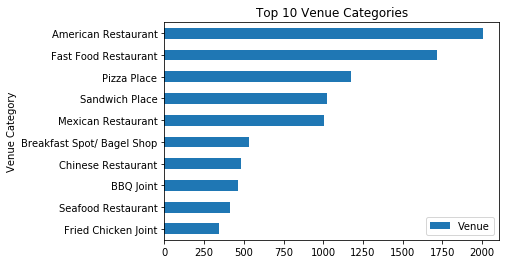

In [76]:
import matplotlib.pyplot as plt
g1.sort_values('Venue',inplace=True)
g1.plot(kind='barh')
plt.title("Top 10 Venue Categories")
plt.show()

In [116]:
# one hot encoding
ga_onehot = pd.get_dummies(ga_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ga_onehot['Neighborhood'] = ga_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ga_onehot.columns[-1]] + list(ga_onehot.columns[:-1])
ga_onehot = ga_onehot[fixed_columns]

ga_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Abbeville, GA",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Abbeville, GA",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
ga_onehot.shape

(13118, 79)

In [118]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
ga_grouped = ga_onehot.groupby('Neighborhood').mean().reset_index()
ga_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.00,0.333333,0.000000,0.00,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
1,"Acworth, GA",0.00,0.160000,0.000000,0.00,0.050000,0.030000,0.000000,0.040000,0.000000,...,0.010000,0.020000,0.0,0.0,0.000000,0.010000,0.01,0.00,0.000000,0.010000
2,"Adairsville, GA",0.00,0.136364,0.090909,0.00,0.045455,0.000000,0.000000,0.045455,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.045455
3,"Adel, GA",0.00,0.130435,0.000000,0.00,0.043478,0.000000,0.000000,0.086957,0.000000,...,0.043478,0.000000,0.0,0.0,0.000000,0.043478,0.00,0.00,0.000000,0.000000
4,"Adrian, GA",0.00,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
5,"Ailey, GA",0.00,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,"Alamo, GA",0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,"Alapaha, GA",0.00,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,"Albany, GA",0.00,0.214286,0.000000,0.00,0.042857,0.014286,0.000000,0.014286,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.028571
9,"Aldora, GA",0.05,0.250000,0.000000,0.00,0.100000,0.000000,0.000000,0.050000,0.000000,...,0.050000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [119]:
print(ga_grouped.shape)
ga_grouped.head()

(471, 79)


,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.0,0.333333,0.000000,0.0,0.333333,0.00,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
1,"Acworth, GA",0.0,0.160000,0.000000,0.0,0.050000,0.03,0.0,0.040000,0.0,...,0.010000,0.02,0.0,0.0,0.0,0.010000,0.01,0.0,0.0,0.010000
2,"Adairsville, GA",0.0,0.136364,0.090909,0.0,0.045455,0.00,0.0,0.045455,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.045455
3,"Adel, GA",0.0,0.130435,0.000000,0.0,0.043478,0.00,0.0,0.086957,0.0,...,0.043478,0.00,0.0,0.0,0.0,0.043478,0.00,0.0,0.0,0.000000
4,"Adrian, GA",0.0,0.000000,0.000000,0.0,0.000000,1.00,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000


In [120]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
import numpy as np
# display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ga_grouped['Neighborhood']

for ind in np.arange(ga_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ga_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(8)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Chinese Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant
2,"Adairsville, GA",Fast Food Restaurant,American Restaurant,Asian Restaurant,Mexican Restaurant,Burger Joint,Wings Joint,Fried Chicken Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot/ Bagel Shop,Steakhouse,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant
4,"Adrian, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
5,"Ailey, GA",Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
6,"Alamo, GA",Burger Joint,Café,Donut Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
7,"Alapaha, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [122]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

ga_grouped_clustering = ga_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ga_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([2, 0, 0, 0, 5, 8, 6, 1, 0, 0, 0, 2, 0, 8, 2, 7, 0, 2, 1, 0],
      dtype=int32)

In [123]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ga_merged = df

# merge ga_grouped with ga_data to add latitude/longitude for each neighborhood
ga_merged = ga_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

ga_merged.head() # check the last columns!

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,2.0,Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,0.0,American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Chinese Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant
2,"Adairsville, GA",34.368702,-84.934109,0.0,Fast Food Restaurant,American Restaurant,Asian Restaurant,Mexican Restaurant,Burger Joint,Wings Joint,Fried Chicken Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",31.137136,-83.423494,0.0,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot/ Bagel Shop,Steakhouse,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant
4,"Adrian, GA",32.530722,-82.589299,5.0,Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [90]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])].shape[0]

68

In [91]:
ga_merged.dropna(inplace=True)

In [92]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])]

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [93]:
ga_merged['Cluster Labels'] = ga_merged['Cluster Labels'].apply(lambda x: int(x) if x == x else 0)
ga_merged.head()

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,2,Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,0,American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Chinese Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant
2,"Adairsville, GA",34.368702,-84.934109,0,Fast Food Restaurant,American Restaurant,Asian Restaurant,Mexican Restaurant,Burger Joint,Wings Joint,Fried Chicken Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",31.137136,-83.423494,0,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot/ Bagel Shop,Steakhouse,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant
4,"Adrian, GA",32.530722,-82.589299,5,Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [36]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [115]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ga_merged['latitude'], ga_merged['longitude'], ga_merged['Name'], ga_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [98]:
# Cluster 1
ga_merged.loc[ga_merged['Cluster Labels'] == 0, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Acworth, GA",American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Chinese Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant
2,"Adairsville, GA",Fast Food Restaurant,American Restaurant,Asian Restaurant,Mexican Restaurant,Burger Joint,Wings Joint,Fried Chicken Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot/ Bagel Shop,Steakhouse,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Sandwich Place,Mexican Restaurant
8,"Albany, GA",Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Seafood Restaurant,Chinese Restaurant,Sandwich Place,BBQ Joint,Wings Joint,Hot Dog Joint,Italian Restaurant
9,"Aldora, GA",American Restaurant,Pizza Place,Fast Food Restaurant,BBQ Joint,African Restaurant,Mexican Restaurant,Breakfast Spot/ Bagel Shop,Steakhouse,Chinese Restaurant,Southern / Soul Food Restaurant
10,"Allenhurst, GA",Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Korean Restaurant,Breakfast Spot/ Bagel Shop,Pizza Place,Seafood Restaurant,Steakhouse,Donut Shop,American Restaurant
12,"Alma, GA",Pizza Place,Fast Food Restaurant,Wings Joint,Fried Chicken Joint,Sandwich Place,Buffet,Diner,BBQ Joint,American Restaurant,Gastropub
17,"Americus, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Southern / Soul Food Restaurant,Hot Dog Joint,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Seafood Restaurant,Cafeteria/ Food Court
20,"Aragon, GA",Fast Food Restaurant,American Restaurant,Breakfast Spot/ Bagel Shop,Pizza Place,Mexican Restaurant,Wings Joint,Sandwich Place,Japanese Restaurant,Southern / Soul Food Restaurant,Fried Chicken Joint
29,"Auburn, GA",American Restaurant,Tex-Mex Restaurant,BBQ Joint,Breakfast Spot/ Bagel Shop,Chinese Restaurant,Sandwich Place,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Eastern European Restaurant


In [39]:
# Cluster 2
ga_merged.loc[ga_merged['Cluster Labels'] == 1, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Alapaha, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
19,"Arabi, GA",American Restaurant,Australian Restaurant,Wings Joint,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
23,"Arlington, GA",American Restaurant,Mexican Restaurant,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
28,"Attapulgus, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
54,"Bluffton, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
61,"Bowman, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
70,"Broxton, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
81,"Calhoun, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
98,"Chattahoochee Hills, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
121,"Coolidge, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [40]:
# Cluster 3
ga_merged.loc[ga_merged['Cluster Labels'] == 2, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
11,"Allentown, GA",American Restaurant,Fast Food Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
14,"Alston, GA",American Restaurant,BBQ Joint,Fast Food Restaurant,Wings Joint,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
18,"Andersonville, GA",Burger Joint,American Restaurant,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
25,"Ashburn, GA",American Restaurant,BBQ Joint,Deli / Bodega,Pizza Place,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Fast Food Restaurant
35,"Baconton, GA",American Restaurant,Breakfast Spot/ Bagel Shop,Wings Joint,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
47,"Between, GA",American Restaurant,Japanese Restaurant,Fast Food Restaurant,Diner,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
48,"Bishop, GA",Vegetarian / Vegan Restaurant,American Restaurant,BBQ Joint,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
60,"Bowersville, GA",American Restaurant,BBQ Joint,Wings Joint,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
88,"Carnesville, GA",American Restaurant,Donut Shop,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant


In [41]:
# Cluster 4
ga_merged.loc[ga_merged['Cluster Labels'] == 3, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
203,"Gibson, GA",Diner,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
207,"Glenwood, GA",Diner,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
401,"Rest Haven, GA",Food Truck/ Food Stand,Diner,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [42]:
# Cluster 5
ga_merged.loc[ga_merged['Cluster Labels'] == 4, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Arcade, GA",Seafood Restaurant,American Restaurant,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
169,"Edge Hill, GA",Seafood Restaurant,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
316,"Midville, GA",Seafood Restaurant,BBQ Joint,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
317,"Midway, GA",Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Mexican Restaurant,Sandwich Place,Diner,Wings Joint,Ethiopian Restaurant,Dumpling Restaurant
364,"Orchard Hill, GA",American Restaurant,Seafood Restaurant,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
381,"Pitts, GA",Diner,Seafood Restaurant,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
484,"Toomsboro, GA",Seafood Restaurant,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant


In [43]:
# Cluster 6
ga_merged.loc[ga_merged['Cluster Labels'] == 5, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Adrian, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
45,"Berlin, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
66,"Bronwood, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [44]:
# Cluster 7
ga_merged.loc[ga_merged['Cluster Labels'] == 6, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Alamo, GA",Burger Joint,Café,Donut Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
57,"Boston, GA",Pizza Place,Café,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
68,"Brooklet, GA",Sandwich Place,Chinese Restaurant,Mexican Restaurant,Café,Wings Joint,Fast Food Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
84,"Canon, GA",Café,Spanish Restaurant,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
150,"Dexter, GA",Café,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
201,"Geneva, GA",Sandwich Place,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
204,"Gillsville, GA",Sandwich Place,Café,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
243,"Homer, GA",Café,Portuguese Restaurant,Fast Food Restaurant,Burger Joint,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck/ Food Stand,Fish & Chips Shop
348,"Nicholson, GA",BBQ Joint,Sandwich Place,Café,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
383,"Plainville, GA",Sandwich Place,Cajun / Creole Restaurant,Café,Wings Joint,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


In [45]:
# Cluster 8
ga_merged.loc[ga_merged['Cluster Labels'] == 7, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Alto, GA",BBQ Joint,Spanish Restaurant,Sandwich Place,Diner,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
46,"Bethlehem, GA",BBQ Joint,Bakery,Breakfast Spot/ Bagel Shop,Wings Joint,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
74,"Buena Vista, GA",BBQ Joint,Sandwich Place,Mexican Restaurant,Pizza Place,Wings Joint,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
112,"Colbert, GA",Hot Dog Joint,BBQ Joint,Bakery,Seafood Restaurant,Wings Joint,Filipino Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
191,"Fort Gaines, GA",BBQ Joint,Fried Chicken Joint,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
333,"Morven, GA",BBQ Joint,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
360,"Offerman, GA",BBQ Joint,Fried Chicken Joint,American Restaurant,Breakfast Spot/ Bagel Shop,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
368,"Patterson, GA",Hot Dog Joint,BBQ Joint,Bakery,Breakfast Spot/ Bagel Shop,Food Truck/ Food Stand,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
427,"Sardis, GA",Southern / Soul Food Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
441,"Smyrna, GA",BBQ Joint,Cafeteria/ Food Court,Mexican Restaurant,Wings Joint,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [46]:
# Cluster 9
ga_merged.loc[ga_merged['Cluster Labels'] == 8, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Ailey, GA",Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
13,"Alpharetta, GA",American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Mediterranean/Greek/Turkish Restaurant,Italian Restaurant,Sandwich Place,Breakfast Spot/ Bagel Shop,Thai Restaurant,Café
24,"Arnoldsville, GA",Mexican Restaurant,Breakfast Spot/ Bagel Shop,Diner,Southern / Soul Food Restaurant,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
26,"Athens, GA",American Restaurant,Mexican Restaurant,Breakfast Spot/ Bagel Shop,Pizza Place,BBQ Joint,Fast Food Restaurant,Sandwich Place,Thai Restaurant,Sushi Restaurant,Steakhouse
27,"Atlanta, GA",American Restaurant,Mexican Restaurant,Pizza Place,Seafood Restaurant,Caribbean Restaurant,Café,Southern / Soul Food Restaurant,Breakfast Spot/ Bagel Shop,Mediterranean/Greek/Turkish Restaurant,Sandwich Place
34,"Avondale Estates, GA",American Restaurant,Pizza Place,Breakfast Spot/ Bagel Shop,Fast Food Restaurant,Mexican Restaurant,Indian Restaurant,Sandwich Place,Gastropub,BBQ Joint,Mediterranean/Greek/Turkish Restaurant
38,"Ball Ground, GA",Donut Shop,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Wings Joint
44,"Berkeley Lake, GA",Mexican Restaurant,American Restaurant,Sandwich Place,Korean Restaurant,Pizza Place,Donut Shop,Indian Restaurant,Wings Joint,Breakfast Spot/ Bagel Shop,Bakery
52,"Bloomingdale, GA",Pizza Place,Mexican Restaurant,Sandwich Place,Chinese Restaurant,American Restaurant,BBQ Joint,Italian Restaurant,Japanese Restaurant,Breakfast Spot/ Bagel Shop,Burger Joint
55,"Blythe, GA",Burger Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [47]:
# Cluster 10
ga_merged.loc[ga_merged['Cluster Labels'] == 9, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
205,"Girard, GA",Southern / Soul Food Restaurant,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
259,"Jersey, GA",Southern / Soul Food Restaurant,Malay Restaurant,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
385,"Portal, GA",Southern / Soul Food Restaurant,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant


In [50]:
ga_grouped_clustering.head()

,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,Burger Joint,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.333333,0.000000,0.0,0.333333,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
1,0.0,0.160000,0.000000,0.0,0.050000,0.03,0.0,0.040000,0.0,0.020000,...,0.010000,0.02,0.0,0.0,0.0,0.010000,0.01,0.0,0.0,0.010000
2,0.0,0.136364,0.090909,0.0,0.045455,0.00,0.0,0.045455,0.0,0.090909,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.045455
3,0.0,0.130435,0.000000,0.0,0.043478,0.00,0.0,0.086957,0.0,0.000000,...,0.043478,0.00,0.0,0.0,0.0,0.043478,0.00,0.0,0.0,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,1.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000


<Figure size 432x288 with 0 Axes>

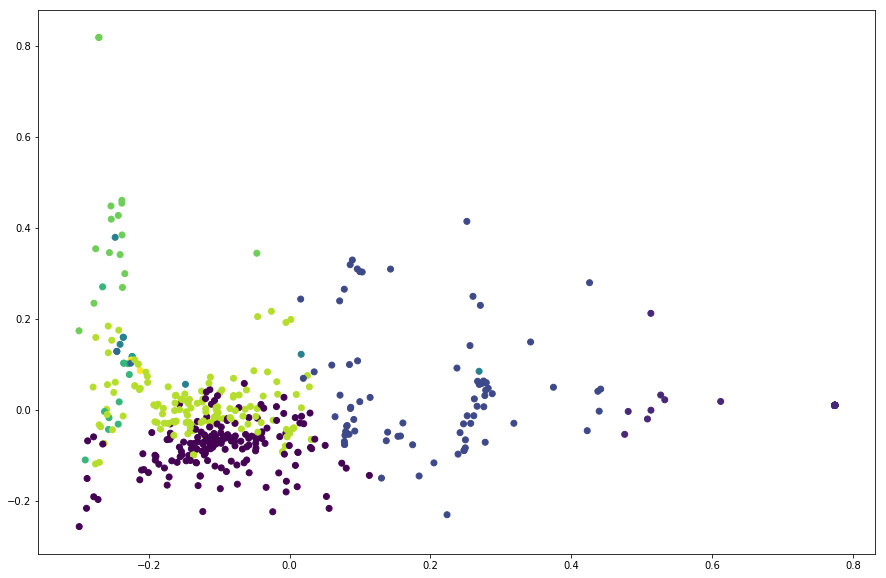

In [52]:
from sklearn.decomposition import PCA
import pylab as pl
%matplotlib inline
pca = PCA(n_components=2).fit(ga_grouped_clustering)
pca_2d = pca.transform(ga_grouped_clustering)
pl.figure('Scatter Plot')
pl.figure(figsize=(15, 10))
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, marker='o')
pl.show()

In [67]:
ga_merged[ga_merged['1st Most Common Venue'].str.contains('Veg')]

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Bishop, GA",33.819286,-83.438772,2,Vegetarian / Vegan Restaurant,American Restaurant,BBQ Joint,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


In [100]:
ga_venues[ga_venues["Venue Category"].str.contains("Veg")].shape[0]

31

In [104]:
ga_veg = ga_venues[ga_venues["Venue Category"].str.contains("Veg")]

# create map of Georgia using latitude and longitude values
map_georgia_veg = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_veg['Venue Latitude'], ga_veg['Venue Longitude'], ga_veg['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_veg)  
    
map_georgia_veg

In [113]:
ga_cafe = ga_venues[ga_venues["Venue Category"].str.contains("Cafe")]

# create map of Georgia using latitude and longitude values
map_georgia_cafe = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_cafe['Venue Latitude'], ga_cafe['Venue Longitude'], ga_cafe['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_cafe)  
    
map_georgia_cafe

In [114]:
ga_southern = ga_venues[ga_venues["Venue Category"].str.contains("Southern")]

# create map of Georgia using latitude and longitude values
map_georgia_s = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_southern['Venue Latitude'], ga_southern['Venue Longitude'], ga_southern['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_s)  
    
map_georgia_s

In [125]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])].head()

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"Ambrose, GA",31.593803,-83.014315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,"Argyle, GA",31.074100,-82.648473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,"Avera, GA",33.194035,-82.527073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,"Barwick, GA",30.890192,-83.740722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,"Bellville, GA",31.594891,-84.899368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
ga_none = ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])]
# create map of Georgia using latitude and longitude values
map_georgia_none = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_none['latitude'], ga_none['longitude'], ga_none['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_none)  
    
map_georgia_none